In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.datasets import ImageFolder
import torchvision.models as models
import numpy as np
import torchvision
from torch.optim import SGD

In [2]:
#checking for device
device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [3]:
#Transforms
transformer=transforms.Compose([
    transforms.Resize((150,150)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(degrees=10),
    transforms.ToTensor(),  #0-255 to 0-1, numpy to tensors
    transforms.Normalize([0.5,0.5,0.5], # 0-1 to [-1,1] , formula (x-mean)/std
                        [0.5,0.5,0.5])
])

In [4]:
#Dataloader

#Path for training and testing directory
train_path='/kaggle/input/png-lensing/png_dataset/train'
val_path='/kaggle/input/png-lensing/png_dataset/val'

train_loader=DataLoader(
    torchvision.datasets.ImageFolder(train_path,transform=transformer),
    batch_size=64, shuffle=True
)
val_loader=DataLoader(
    torchvision.datasets.ImageFolder(val_path,transform=transformer),
    batch_size=32, shuffle=True
)

In [5]:
#categories
import pathlib
root=pathlib.Path(train_path)
classes=sorted([j.name.split('/')[-1] for j in root.iterdir()])
print(classes)

['no', 'sphere', 'vort']


In [6]:
# Define the size of the image grid
grid_size = 150

# Initialize an empty tensor to store distances
r2 = torch.zeros(grid_size * grid_size)

# Compute distances for each pixel
for i in range(grid_size):
    for j in range(grid_size):
        r2[grid_size * i + j] = ((74.5 - i) ** 2 + (74.5 - j) ** 2)

# Verify the size of dis
print("Size of dis tensor:", r2.size())

# Find the maximum value in the r2 tensor
max_r2 = r2.max()
normalized_r2 = r2/max_r2

# Move r2 tensor to CUDA if available
normalized_r2 = normalized_r2.cuda()

Size of dis tensor: torch.Size([22500])


In [7]:
class LensClassifier(nn.Module):
    def __init__(self,normalized_r2):
        super(LensClassifier, self).__init__()
        self.normalized_r2 = normalized_r2
        
        # Add a global average pooling layer
        self.avgpool = nn.AdaptiveAvgPool2d(1)
    
        # Step 2: Use ResNet-18 for vector A
        self.resnet_A = models.resnet18(pretrained=True)
        self.features_A = nn.Sequential(*list(self.resnet_A.children())[:-2])
            
        # Step 3: Use another ResNet-18 for vector B
        self.resnet_B = models.resnet18(pretrained=True)
        self.features_B = nn.Sequential(*list(self.resnet_B.children())[:-2])
         
        #self.features_B.add_module('avgpool', nn.AdaptiveAvgPool2d(1))
        self.features_B.add_module('flatten', nn.Flatten())
        self.features_B.add_module('dropout', nn.Dropout(p=0.5))  # Adding dropout layer
        self.relu = nn.ReLU(inplace=True)
        self.features_B.add_module('linear', nn.Linear(12800, 22500))
        
        
        # Step 5: Neural layer and softmax
        self.neural_layer1 = nn.Linear(35300,5625 )
        self.neural_layer2 = nn.Linear(5625, 128)
        self.neural_layer3 = nn.Linear(128, 3)
        self.dropout = nn.Dropout(p=0.4)  # Adding dropout layer
             
        
    def forward(self, x):
        
        # Select the first channel along the second dimension
        x_first_channel = x[:, :1, :, :]
        x_second_channel = x[:, :1, :, :]
        x_third_channel = x[:, :1, :, :]
        x_single_channel = (x_first_channel + x_second_channel + x_third_channel)/3
        # Reshape the tensor
        
        I = x_single_channel.view(x.size(0), -1)
        I = I.detach()
        
        # Step 2: Extract features A
        features_A = self.features_A(x)
        #features_A = self.avgpool(x)
        features_A = features_A.view(features_A.size(0), -1)
        
        # Step 3: Extract features B
        features_B = self.features_B(x)
        features_B = self.relu(features_B)
        features_B = features_B.view(features_B.size(0), -1)
        
        # Step 4: Physics equation C = I - B * (distance from center of image)
        C = I - features_B * self.normalized_r2
        
        # Step 4: Concatenate A and C
        D = torch.cat([features_A, C], dim=1)
        
        # Step 5: Neural layer and softmax
        output = self.neural_layer1(D)
        output = self.relu(output)
        output = self.dropout(output)
        
        output = self.neural_layer2(output)
        output = self.relu(output)
        output = self.dropout(output) # Applying dropout
        
        output = self.neural_layer3(output)
        
        return output

In [8]:
# Initialize the LensClassifier with fixed I and normalized_r2
model = LensClassifier(normalized_r2)
model.to(device)

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 146MB/s] 


LensClassifier(
  (avgpool): AdaptiveAvgPool2d(output_size=1)
  (resnet_A): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm

In [9]:
pip install torchsummary

Note: you may need to restart the kernel to use updated packages.


In [10]:
from torchsummary import summary
summary(model, (3, 150, 150))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 75, 75]           9,408
            Conv2d-2           [-1, 64, 75, 75]           9,408
       BatchNorm2d-3           [-1, 64, 75, 75]             128
       BatchNorm2d-4           [-1, 64, 75, 75]             128
              ReLU-5           [-1, 64, 75, 75]               0
              ReLU-6           [-1, 64, 75, 75]               0
         MaxPool2d-7           [-1, 64, 38, 38]               0
         MaxPool2d-8           [-1, 64, 38, 38]               0
            Conv2d-9           [-1, 64, 38, 38]          36,864
           Conv2d-10           [-1, 64, 38, 38]          36,864
      BatchNorm2d-11           [-1, 64, 38, 38]             128
      BatchNorm2d-12           [-1, 64, 38, 38]             128
             ReLU-13           [-1, 64, 38, 38]               0
             ReLU-14           [-1, 64,

In [11]:

# Define RAdam optimizer
optimizer = SGD(model.parameters(), lr=0.01, weight_decay=0.0001)
# Define BCE loss function
loss_function = nn.CrossEntropyLoss()

In [12]:
from torch.optim.lr_scheduler import StepLR

# Define the scheduler
scheduler = StepLR(optimizer, step_size=3, gamma=0.1, verbose=True)

Adjusting learning rate of group 0 to 1.0000e-02.


In [13]:
num_epochs=10

In [14]:
#calculating the size of training and testing images
train_count=3*10000
test_count=3*1500
print(train_count,test_count)

30000 4500


In [15]:
from torch.autograd import Variable

In [16]:
import torch.nn.utils as torch_utils

best_accuracy = 0.0

for epoch in range(num_epochs):
    
    # Evaluation and training on training dataset
    model.train()
    train_accuracy = 0.0
    train_loss = 0.0
    
    for i, (images, labels) in enumerate(train_loader):
        if torch.cuda.is_available():
            images = images.cuda()
            labels = labels.cuda()
            
        optimizer.zero_grad()
        outputs = model(images)
        loss = loss_function(outputs, labels)
        loss.backward()
        
        optimizer.step()
        
        train_loss += loss.item() * images.size(0)
        _, prediction = torch.max(outputs.data, 1)
        train_accuracy += int(torch.sum(prediction == labels.data))
        
    train_accuracy = train_accuracy / train_count
    train_loss = train_loss / train_count
    
    # Evaluation on testing dataset
    model.eval()
    
    test_accuracy = 0.0
    for i, (images, labels) in enumerate(val_loader):
        if torch.cuda.is_available():
            images = images.cuda()
            labels = labels.cuda()
            
        outputs = model(images)
        _, prediction = torch.max(outputs.data, 1)
        test_accuracy += int(torch.sum(prediction == labels.data))
    
    test_accuracy = test_accuracy / test_count
    
    # Step the scheduler
    #scheduler.step()
    
    print('Epoch: ' + str(epoch) + ' Train Loss: ' + str(train_loss) + ' Train Accuracy: ' + str(train_accuracy) + ' val Accuracy: ' + str(test_accuracy))
    
    # Save the best model
    if test_accuracy > best_accuracy:
        torch.save(model.state_dict(), 'best_checkpoint.model')
        best_accuracy = test_accuracy

Epoch: 0 Train Loss: 1.1009986488342285 Train Accuracy: 0.3324 val Accuracy: 0.3333333333333333
Epoch: 1 Train Loss: 1.0974482173283895 Train Accuracy: 0.348 val Accuracy: 0.36733333333333335
Epoch: 2 Train Loss: 1.0662995800971984 Train Accuracy: 0.4015 val Accuracy: 0.41244444444444445
Epoch: 3 Train Loss: 0.9220697057088216 Train Accuracy: 0.5286 val Accuracy: 0.5124444444444445
Epoch: 4 Train Loss: 0.7457511106173197 Train Accuracy: 0.6638 val Accuracy: 0.6642222222222223
Epoch: 5 Train Loss: 0.6121578478177389 Train Accuracy: 0.7417333333333334 val Accuracy: 0.7575555555555555
Epoch: 6 Train Loss: 0.5250513339678446 Train Accuracy: 0.7831666666666667 val Accuracy: 0.7384444444444445
Epoch: 7 Train Loss: 0.47789980924924214 Train Accuracy: 0.8081333333333334 val Accuracy: 0.7791111111111111
Epoch: 8 Train Loss: 0.44037949363390605 Train Accuracy: 0.8279 val Accuracy: 0.8022222222222222
Epoch: 9 Train Loss: 0.4112187815030416 Train Accuracy: 0.8386333333333333 val Accuracy: 0.783111

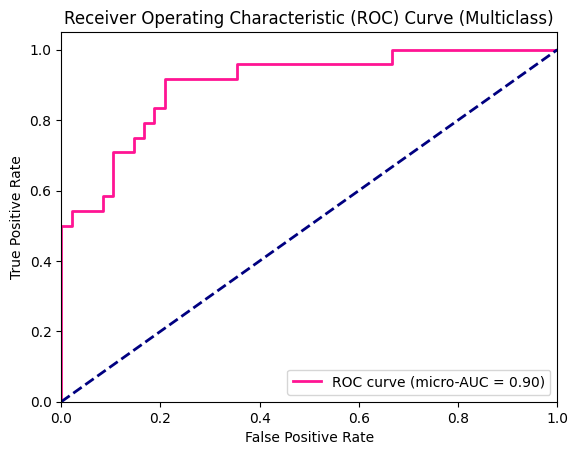

In [23]:
test_path='/kaggle/input/png-lensing/png_dataset/test'
test_loader=DataLoader(
    torchvision.datasets.ImageFolder(test_path,transform=transformer),
    batch_size=32, shuffle=True
)
for i, (images,labels) in enumerate(test_loader):
        if torch.cuda.is_available():
            images=Variable(images.cuda())
            labels=Variable(labels.cuda())
            
        y_score=model(images)
        y_true=labels
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

# Example ground truth and predicted probabilities for multiclass
# Replace these arrays with your actual ground truth and predicted probabilities
y_score = y_score.detach().cpu().numpy() 
y_true = y_true.detach().cpu().numpy()

# Binarize the ground truth labels
y_true_bin = label_binarize(y_true, classes=np.unique(y_true))

# Compute ROC curve and ROC area for each class
n_classes = y_score.shape[1]
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_true_bin.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Plot ROC curve
plt.figure()
plt.plot(fpr["micro"], tpr["micro"], color='deeppink', lw=2, label=f'ROC curve (micro-AUC = {roc_auc["micro"]:0.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve (Multiclass)')
plt.legend(loc='lower right')
plt.show()